<a href="https://colab.research.google.com/github/aysebren/car_park_detection/blob/master/ModelWithCNRandSave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn

  Cloning https://github.com/datumbox/keras (to revision bugfix/trainable_bn) to /tmp/pip-req-build-8f97ldxv
  Running command git clone -q https://github.com/datumbox/keras /tmp/pip-req-build-8f97ldxv
  Running command git checkout -b bugfix/trainable_bn --track origin/bugfix/trainable_bn
  Switched to a new branch 'bugfix/trainable_bn'
  Branch 'bugfix/trainable_bn' set up to track remote branch 'bugfix/trainable_bn' from 'origin'.
  Created wheel for Keras: filename=Keras-2.2.4-cp36-none-any.whl size=311046 sha256=4a3f04648bb4206b237727bac5419f9b0724e7ea24f4e0193137cd39bc293c7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-wky0vuf0/wheels/36/5d/50/99c268bf64c1394c4f5b743164e4e515ab30290a523595ac47
Successfully built Keras
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
!pip install livelossplot

In [ ]:
from google.colab import drive, files
import keras
import keras.utils
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization,GlobalAveragePooling2D
import livelossplot
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras import backend as K

In [ ]:

plot_losses = livelossplot.PlotLossesKeras()

IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 64
TEST_SIZE = 30
seed=42
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

model = Sequential()
K.set_learning_phase(1)
np.random.seed(seed)
base_model = ResNet50(weights='imagenet', include_top=False)

# for layer in model.layers[:140]:
#    layer.trainable = False

# for layer in model.layers[140:]:
#    layer.trainable = True


alpha = 0.00002  # weight decay coefficient

for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

initial_lrate=0.01
iteration=200
decay=0.01
lrate = initial_lrate * (1 / (1 + decay * iteration))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
#x = Dropout(0.7)(x)
x = Dense(2, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=lrate),
            metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step





In [ ]:


path = "/content/drive/My Drive/CNRPark-Patches-150x150/"
#path = "/content/drive/My Drive/pklotmix/"
train_data_dir = path + "Train"
valid_data_dir = path + "Validation"


# Data augmentation

training_data_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# Data preparation
training_generator = training_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")


# Validation Data augmentation
valid_data_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rescale=1./255)

# Validation Data preparation
valid_generator = training_data_generator.flow_from_directory(
    valid_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")




Found 10066 images belonging to 2 classes.
Found 3240 images belonging to 2 classes.


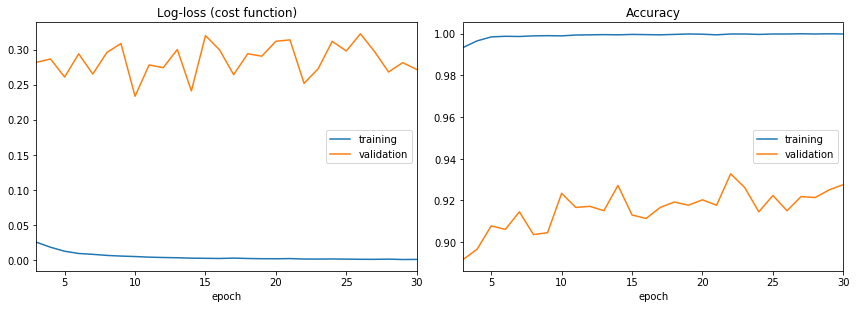

Log-loss (cost function):
training   (min:    0.001, max:    0.120, cur:    0.001)
validation (min:    0.234, max:    0.323, cur:    0.272)

Accuracy:
training   (min:    0.961, max:    1.000, cur:    1.000)
validation (min:    0.874, max:    0.933, cur:    0.928)


In [ ]:
K.set_learning_phase(1)
history = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[plot_losses],
    validation_data = valid_generator,
    validation_steps = 30,
    verbose=1)


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('mymodelcnr.h5')
model_file = drive.CreateFile({'title' : 'mymodelcnr.h5'})
model_file.SetContentFile('mymodelcnr.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1es2IQNnOnn37Wl_BGXU6DpbCy98YRkH_'})

In [ ]:
model.save_weights('mymodelcnr_weights.h5')
weight_file = drive.CreateFile({'title' : 'mymodelcnr_weights.h5'})
weight_file.SetContentFile('mymodelcnr_weights.h5')
weight_file.Upload()

# download to google drive
drive.CreateFile({'id': weight_file.get('id')})

GoogleDriveFile({'id': '1ObFdF2HcGT5DLrX_qJligw9T73EX-iCk'})

In [ ]:
K.set_learning_phase(0)
#test_data_dir = "/content/drive/My Drive/pklotmix/train1/"
test_data_dir = "/content/drive/My Drive/test/"
test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function=keras.applications.resnet50.preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=2,
    class_mode="categorical",
    shuffle=False)

Found 2518 images belonging to 2 classes.


In [ ]:
score=model.evaluate_generator(test_generator,steps=len(test_generator.filenames)//8)

print(score[0])
print(score[1])

0.02380078928964122
0.9952229299363057


In [ ]:
test_generator.reset()

In [ ]:
K.set_learning_phase(0)
test_data_dir = "/content/drive/My Drive/pklotmix/test/"
#test_data_dir = "/content/drive/My Drive/test/"
test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function=keras.applications.resnet50.preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=2,
    class_mode="categorical",
    shuffle=False)

Found 2244 images belonging to 2 classes.


In [ ]:
score=model.evaluate_generator(test_generator,steps=len(test_generator.filenames)//8)

print(score[0])
print(score[1])

0.04228560100018512
0.9928571428571429


In [ ]:
import os
os.chdir("/content/drive/My Drive/")

In [ ]:
from keras.models import load_model

model = load_model('mymodelcnr.h5')
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


